In [2]:
import numpy as np
import matplotlib.pyplot as pp
import torch
import gflownet.tasks.qm9.qm9 as qm9
from gflownet.tasks.qm9.qm9 import RewardInfo, gap_reward, logP_reward, molecular_weight_reward, qed_reward
from gflownet.models.mxmnet import MXMNet, Config, mol2graph
from gflownet.models.graph_transformer import GraphTransformerGFN
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import numpy as np
from torch_geometric import data as gd
from rdkit.Chem import AllChem
from torch.distributions.dirichlet import Dirichlet


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Data and Reward Functions

In [3]:
data_train = qm9.QM9Dataset('/data/chem/qm9/qm9_new.h5', targets=["gap", "logP", "molecular_weight", "QED"], ratio=1.0)
# data_test = qm9.QM9Dataset('/data/chem/qm9/qm9.h5', train=False, targets=["gap", "logP", "molecular_weight", "QED"])

In [14]:
import pandas as pd
data_train.df.to_hdf('/sandbox/qm9_new.h5', key='df', mode='w')  
# pd.DataFrame.to_hdf(path_or_buf=data_train.df, key='/data/chem/qm9/qm9_new.h5')

In [88]:
targets=["gap", "logP", "QED", "molecular_weight"]
number_of_objectives=4
reward_stat_info = []
for i in range(number_of_objectives):
    _min, _max, _median,  _percentile_95 = data_train.get_stats(percentile=0.05, target=targets[i])
    reward_stat_info.append(RewardInfo(_min=_min, _max=_max, _median=_median, _percentile_95=_percentile_95))

### Instantiate the environment

In [64]:
def env_init(cond_dim):
    env = qm9.GraphBuildingEnv()
    ctx = qm9.MolBuildingEnvContext(['H', 'C', 'N', 'F', 'O'], num_cond_dim=cond_dim)
    return env, ctx

In [65]:
def init_model(key, ctx, seed, hidden_dim, num_layers=4):
    model = GraphTransformerGFN(ctx, hidden_dim, num_layers)
    #key = "5bf39185-b140-40a0-a50f-006d6f278847" # temp 32, 38k training steps (min val)
    params = torch.load(f"/sandbox/qm9_results/{key}/state_dict.pth")
    model.load_state_dict(params['models_state_dict'][0])
    model.cuda(); model.device = torch.device('cuda')
    return model

In [80]:
trial = client.get_trial("176349")
best_checkpoint = trial.top_checkpoint()
print(best_checkpoint)

Checkpoint(uuid=36f63ebe-012e-4b02-b7ed-777741f62f65, task_id=23258.080ad1e0-e8fb-4072-9962-57f342ca5ad3, trial_id=176349)


In [83]:
infos = [
    ["176177", "const,", 1, "Dirac 8"],
    ["176172", "const", 2, "Dirac 8"],
    # ["176173", "const", 3, "Dirac 8"],
    # ["176170", "const", 4, "Dirac 8"],
    # ["176174", "uniform,", 1, "Uniform"],
    ["176175", "uniform,", 2, "Uniform"],
    # ["176176", "uniform,", 3, "Uniform"],
    # ["176179", "uniform,", 4, "Uniform"],
    ["176181", "gamma,", 1, "Gamma"],
    ["176178", "gamma,", 2, "Gamma"],
    ["176171", "gamma", 3, "Gamma"],
    # ["176180", "gamma,", 4, "Gamma"],
]

for info in infos:
    env, ctx = env_init(32 + info[2])
    trial = client.get_trial(info[0])
    best_checkpoint = trial.top_checkpoint()
    model = init_model(best_checkpoint.uuid, ctx, 1, 256, 5)

In [84]:
def load_mxnet():
    mxmn = MXMNet(Config(128, 6, 5.0))
    state_dict = torch.load('/data/chem/qm9/mxmnet_gap_model.pt', map_location=torch.device('cpu'))
    mxmn.load_state_dict(state_dict)
    mxmn.cuda(); mxmn.device = torch.device('cuda')
    return mxmn
mxmnet = load_mxnet()

In [92]:
def compute_flat_rewards(mols, mxmnet, targets, reward_info, number_of_objectives):
    all_preds = []
    graphs = [mxmnet.mol2graph(i) for i in mols]  # type: ignore[attr-defined]
    is_valid = torch.tensor([i is not None for i in graphs]).bool()
    if not is_valid.any():
        return torch.zeros((0,)), is_valid
    for target in targets:
        if target == 'gap':
            batch = gd.Batch.from_data_list([i for i in graphs if i is not None])
            batch.to(self.device)
            preds = self.models['mxmnet_gap'](batch).reshape((-1, 1)).data.cpu().numpy() / mxmnet.HAR2EV  # type: ignore[attr-defined]                
        elif target == 'logP':
            preds = np.asarray([Descriptors.MolLogP(i) for idx, i in enumerate(mols) if graphs[idx] is not None]).reshape((-1,1 ))
        elif target == 'molecular_weight':
            preds = np.asarray([Descriptors.MolWt(i) for idx, i in enumerate(mols) if graphs[idx] is not None]).reshape((-1, 1))
        elif target == 'QED':
            preds = np.asarray([Descriptors.qed(i) for idx, i in enumerate(mols) if graphs[idx] is not None]).reshape((-1, 1))
        else:
            preds = []
        preds[np.isnan(preds)] = 1
        all_preds.append(preds)
    all_preds = np.hstack(all_preds)
    preds = flat_reward_transform(all_preds, reward_info, targets, number_of_objectives) # TODO: Is this clipping valid for all the rewards?
    return preds.clip(1e-4, 2), is_valid
    
def flat_reward_transform(y, reward_stat_info, targets, number_of_objectives):
    if isinstance(y, list):
        y = np.vstack(y)
    rewards = []
    for i in range(number_of_objectives):
        rew = transform(y[:, i], reward_stat_info[i], targets[i])
        rewards.append(rew)
    rewards = np.vstack(rewards).reshape(-1, number_of_objectives)
    return rewards

def transform(self, y, reward_stat_info, target: str):
    if target == 'gap':
        return gap_reward(y, reward_stat_info)
    elif target == 'logP':
        return logP_reward(y, reward_stat_info)
    elif target == 'molecular_weight':
        return molecular_weight_reward(y, reward_stat_info)
    elif target == 'QED':
        return qed_reward(y, reward_stat_info)


In [103]:
def sample_trajectories(model, env, ctx, number_of_objectives, targets):
    hps={
        
        'random_action_prob': 0.0,
        'illegal_action_logreward': -50,
        'bootstrap_own_reward': False,
        'tb_epsilon': None,
        'reward_loss_multiplier': 2
    }
    sampler = qm9.TrajectoryBalance(env, ctx, np.random.default_rng(142857),
                                    hps, max_nodes=9)
    model.device = torch.device('cuda')
    ctx.device = model.device
    temp_res = {}
    for temp in [1,8,16,24,32]:
        temp_res[temp] = []
        for i in range(5):
            m = Dirichlet(torch.tensor([1.5] * number_of_objectives))
            preferences = m.sample([64]).cuda()
            beta_enc = qm9.thermometer(torch.ones(64) * temp, 32, 0, 32).cuda()
            cond_info = torch.cat([preferences, beta_enc], dim=-1)
            data = sampler.create_training_data_from_own_samples(model, 64, cond_info)
            try:
                mols = [ctx.graph_to_mol(i['traj'][-1][0]) for i in data if i is not None]
            except:
                print("Skipped")
                continue
            graphs = [mol2graph(ctx.graph_to_mol(i['traj'][-1][0])) if i['is_valid'] else None for i in data]
            is_valid = torch.tensor([i is not None for i in graphs]).bool()
            preds, m_is_valid = compute_flat_rewards(mols,mxmnet, targets, reward_stat_info, 3 ).clip(1e-4, 2)                
            preds_mask = preds.isnan()
            preds[preds_mask] = 1
            preds = data_train.reward_transform(preds).clip(1e-4, 2)
            rewards = torch.zeros(len(data))
            rewards[is_valid] = preds
            for i, j in enumerate([j for j in range(len(data)) if graphs[j] is not None]):
                is_valid[j] = not preds_mask[i]
            for i, v in zip(data, is_valid):
                i['is_valid'] = v
            temp_res[temp] += [(i['traj'][-1][0], 
                                r.log(), 
                                i['fwd_logprob'],
                                i['traj'], i) for i,r in zip(data, rewards)]
            return preds
    

In [104]:
sample_trajectories(model, env, ctx, 3, targets[:3])

Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped


AttributeError: 'MXMNet' object has no attribute 'mol2graph'

1 0.5334250164958382 15.62% valid 15.62% valid
8 0.5369166609201139 10.62% valid 10.62% valid
16 0.5335742585305095 10.94% valid 10.94% valid
24 0.5213824496079298 14.69% valid 14.37% valid
32 0.5285328946524361 5.62% valid 5.62% valid


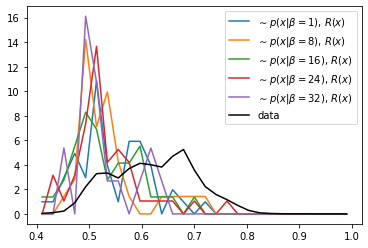

In [125]:
rewards = [[np.exp(i[1].item()) for i in temp_res[t] if i[1] > -50] for t in sorted(temp_res)]
space = np.linspace(0.4,1,30)
dists = [np.histogram(i, space, density=True) for i in rewards] + [np.histogram(data_train.reward_transform(data_train.df['gap']), space, density=True)]
for t, (d, bins), j in zip(sorted(temp_res), dists, range(len(temp_res))):
    l, = pp.plot(bins[:-1] + bins[1]/2 - bins[0]/2, d, 
                 label=f'$\sim p(x|\\beta={t})$, $R(x)$')
    print(t, np.mean(rewards[j]),
          f'{100 * np.mean([i[1].cpu().item() > -50 for i in temp_res[t]]):.2f}% valid',
          f'{100 * np.mean([i[4]["is_valid"] for i in temp_res[t]]):.2f}% valid')
l, = pp.plot(bins[:-1] + bins[1]/2 - bins[0]/2, dists[-1][0], 
             label=f'data', color='black')
pp.legend()

In [126]:
print("Validity rates (rdkit):")
print(*[f'{t:3d} {100 * np.mean([i[1].cpu().item() > -50 for i in temp_res[t]]):.2f}%' for t in sorted(temp_res)])

Validity rates (rdkit):
  1 15.62%   8 10.62%  16 10.94%  24 14.69%  32 5.62%


In [65]:
data = sampler.create_training_data_from_own_samples(
    model, 100, torch.tensor(np.random.uniform(0.2, 32, 100)).float().cuda()[:, None])

In [66]:
print(np.mean([i['is_valid'] for i in data]))

0.97


------------

[NH+]=[N+]1[C-]C=[C-]N=[NH+][C-]=[C-]1
[C]=[C-]C1=[C-][CH-][N+](=[N])[C+]1[CH2-]
[C-]C([C-]=[C-][NH+]=[N])=[C-]N[O+]
[O+]=C1[N+]=[C-][C-][C-]=C=[N+]=[N+]1
[C-][C-]=C1[C-]=C([N])N([NH3+])O1
[C]=C1[N-][C]=[C-]N1C([CH2+])=O
[C]NC(=N[C+][C+])[N+](=[C+])[CH]
[C]=[NH+][C-][C+]=[C][NH+]=[C][N+]
[C]=[C+]([C+]C([C-])=N[CH2+])C=[CH-]
[C][N][CH-][C-][C-]=[C-][C-]=[C][CH2+]
[C-]C1=N[N+](=[CH-])[C-]=[C-][C+]N1
[C]N=[C-][C+]=[C-]C(=[NH2+])[C+][NH-]
[N+][CH-]C=C1[C+]=[C+][C-][C-]=[C-]1
[CH+][O+]N([N])[C-]=[C-][C+]=[C-][FH+]
[CH2+][C-]1[C-][C+]=[C+]([N-])[N+]([CH2+])=[C-]1
[C-][N-]C(=[C][N-][N])[C-][N-][FH+]


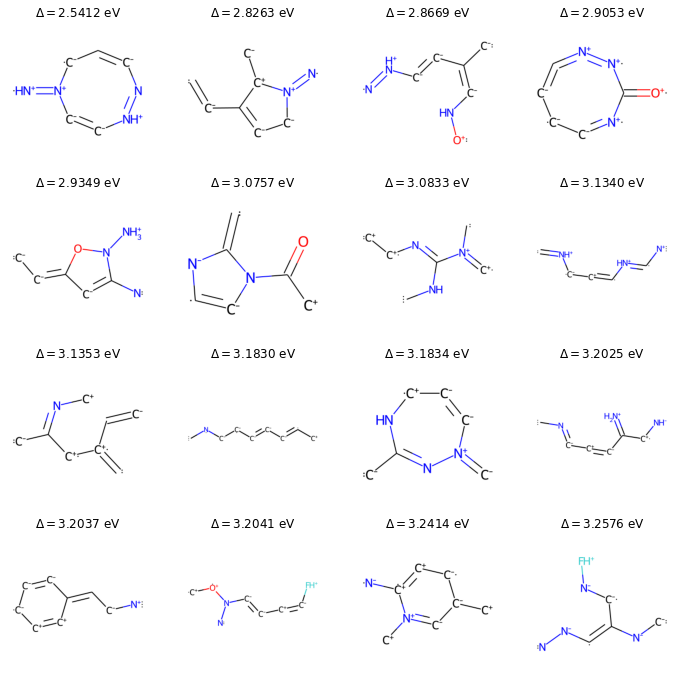

In [9]:
import rdkit.Chem.AllChem as AllChem
f, ax = pp.subplots(4,4,figsize=(12,12))
which_temp = 32
rewards = [temp_res[which_temp][i][1].exp() for i in range(len(temp_res[which_temp]))]
best_k = np.argsort(rewards)[::-1]
new_rs = []
for i in range(len(rewards)):
    #r = rewards[best_k[i]]
    r = (1 - rewards[best_k[i]]) * (data_train._gap + 1e-4) + data_train._min
    try:
        mol = ctx.graph_to_mol(temp_res[which_temp][best_k[i]][0])
        s = Chem.MolToSmiles(mol)
        mp = Chem.MolFromSmiles(s)
    except Exception as e:
        continue
    if mp is None:
        continue
    new_rs.append((mol, r))
for i in range(min(16, len(new_rs))):
    pp.sca(ax[i // 4, i % 4])
    mol, r = new_rs[i]
    pp.title(f'$\\Delta = {r * 27.2113825435:.4f}$ eV')
    print(Chem.MolToSmiles(mol))
    pp.axis('off')
    try:
        img = Chem.Draw.MolToImage(mol)
    except:
        pass
    pp.imshow(img)

In [12]:
for mol, r in new_rs:
    print(Chem.MolToSmiles(mol))
    print(f"{r.item():.4f} Ha, {r.item() * 27.21:.4f} eV")

[NH+]=[N+]1[C-]C=[C-]N=[NH+][C-]=[C-]1
0.0934 Ha, 2.5411 eV
[C]=[C-]C1=[C-][CH-][N+](=[N])[C+]1[CH2-]
0.1039 Ha, 2.8261 eV
[C-]C([C-]=[C-][NH+]=[N])=[C-]N[O+]
0.1054 Ha, 2.8668 eV
[O+]=C1[N+]=[C-][C-][C-]=C=[N+]=[N+]1
0.1068 Ha, 2.9052 eV
[C-][C-]=C1[C-]=C([N])N([NH3+])O1
0.1079 Ha, 2.9347 eV
[C]=C1[N-][C]=[C-]N1C([CH2+])=O
0.1130 Ha, 3.0755 eV
[C]NC(=N[C+][C+])[N+](=[C+])[CH]
0.1133 Ha, 3.0831 eV
[C]=[NH+][C-][C+]=[C][NH+]=[C][N+]
0.1152 Ha, 3.1338 eV
[C]=[C+]([C+]C([C-])=N[CH2+])C=[CH-]
0.1152 Ha, 3.1352 eV
[C][N][CH-][C-][C-]=[C-][C-]=[C][CH2+]
0.1170 Ha, 3.1828 eV
[C-]C1=N[N+](=[CH-])[C-]=[C-][C+]N1
0.1170 Ha, 3.1832 eV
[C]N=[C-][C+]=[C-]C(=[NH2+])[C+][NH-]
0.1177 Ha, 3.2023 eV
[N+][CH-]C=C1[C+]=[C+][C-][C-]=[C-]1
0.1177 Ha, 3.2036 eV
[CH+][O+]N([N])[C-]=[C-][C+]=[C-][FH+]
0.1177 Ha, 3.2040 eV
[CH2+][C-]1[C-][C+]=[C+]([N-])[N+]([CH2+])=[C-]1
0.1191 Ha, 3.2413 eV
[C-][N-]C(=[C][N-][N])[C-][N-][FH+]
0.1197 Ha, 3.2575 eV
[N+]=C1[C-]N(C=[NH+])N=[C+]1[NH-]
0.1202 Ha, 3.2714 eV
[C][OH+][

Text(0.5, 0, 'SA score')

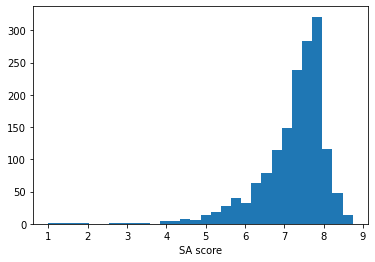

In [18]:
import sascore
def tryf(m):
    try:
        return ctx.graph_to_mol(m)
    except:
        return None
smiles = [tryf(i[0]) for t in temp_res for i in temp_res[t]]
scores = [sascore.calculateScore(i) for i in smiles if i is not None]
pp.hist(scores, 30);
pp.xlabel('SA score')

[C-]=C([O])[C-]=[N+][C+]1=[O+][NH2+][CH+]1
[CH2-]C(=N[NH])[O+][OH+][N+]=[C+][F+]
[CH2][C+][O+]=[N+][N][N]N=C[OH2+]
N=C([O])[C-]([O-])[N+]N[C+]=[NH+]
C[C+]=[C][N-][N-][O+]=[C-][O+]=O
[C-]=[C+][C-]1[C+]=[C-][N+][OH+]C1=[NH2+]
[CH2+]NC=N[CH-]C(=N)[N+]=[OH+]
[C]=[C-][CH+][C+]([C+][C+])[N+]([CH])=[NH2+]
[C-][NH+]1[CH-]OC(=[C+][O+])[C+]1[CH2]
[CH2+][N][C]=[C+][CH+][O+]1[C+][N+]=N1
[C][N+][C+]([NH-])[N+][NH+]=N[N-][CH2+]
[CH-]=NC1([N+])[N-][C-]1C[F+][NH-]


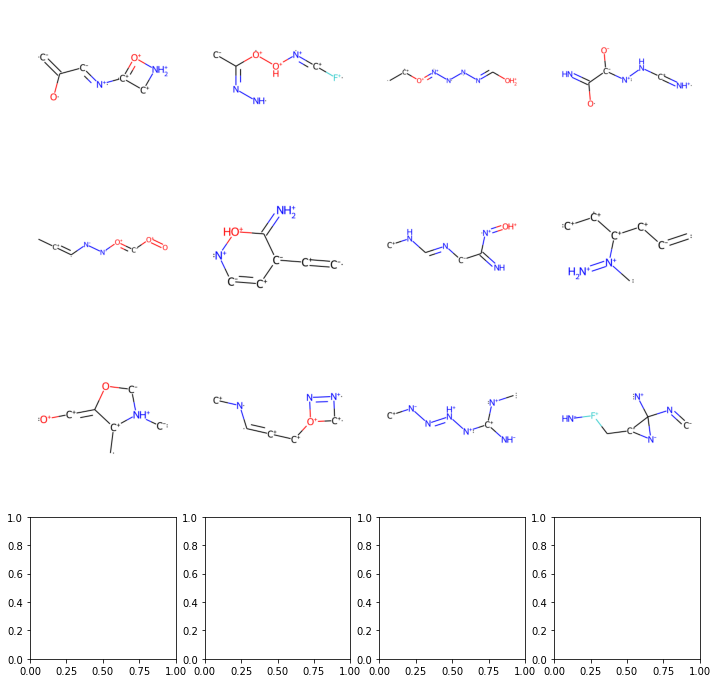

In [17]:
f, ax = pp.subplots(4,4,figsize=(12,12))
i = 0
for m, s in zip(smiles, scores):
    if s < 4:
        print(Chem.MolToSmiles(m))
        pp.sca(ax[i // 4, i % 4])
        pp.axis('off')
        img = Chem.Draw.MolToImage(m)
        pp.imshow(img)
        i += 1

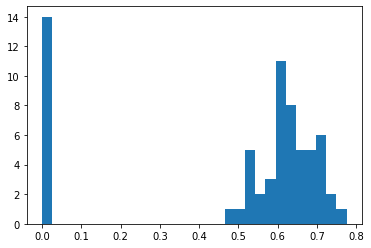

In [128]:
pp.hist(np.float32(rewards).reshape(-1), 30);

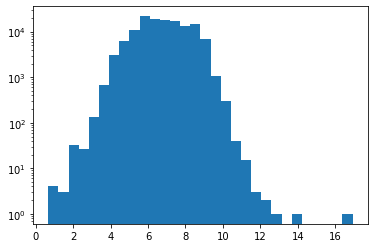

In [47]:
pp.hist(data_train.df['gap'] * 27.2113825435, 30);
pp.yscale('log')

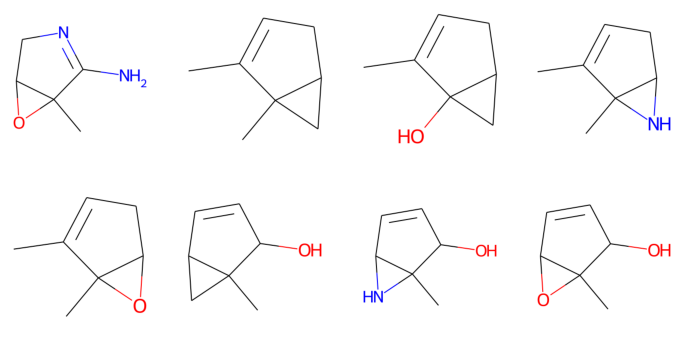

In [32]:
f, ax = pp.subplots(2,4,figsize=(12,6))
idcs = np.argsort(preds)
for i in range(min(8, len(preds))):
    pp.sca(ax[i // 4, i % 4])
    j = idcs[i]
    mol = Chem.MolFromSmiles(data_train.df['SMILES'][13000+i])
    pp.axis('off')
    try:
        img = Chem.Draw.MolToImage(mol)
    except:
        pass
    pp.imshow(img)

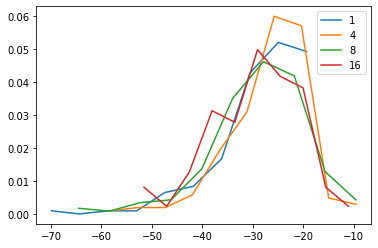

In [91]:
for temp in sorted(temp_res):
    h, b = np.histogram([i[2].item() for i in temp_res[temp]], density=True)
    pp.plot(b[1:]-(b[1]-b[0])/2, h, label=str(temp))
pp.legend()

In [102]:
model = qm9.Model(ctx, 64)

In [52]:
key = "cb5cc75e-3e54-48d7-a7b4-d9517beec2b6" # lr 1e-5
key = "018b13e2-1fc6-42df-8766-7f0dcf3f4812" # lr 5e-5
params = torch.load(f"/mnt/bh1/scratch/det_checkpoints/{key}/state_dict.pth")
model.load_state_dict(params['models_state_dict'][0])
model.cuda(); model.device = torch.device('cuda')

In [135]:
from torch_scatter import scatter
sampler = qm9.TrajectoryBalance(env, ctx, np.random.default_rng(142857),
                                random_action_prob=0, max_nodes=9)
dev = model.device
inv_preds = []
preds = []
temps = []
Zs = []
fwd_probs = []
targets = []
errs = []
all_rewards = []
for smiles, rewards in dl_train:
    graphs = [ctx.mol_to_graph(Chem.MolFromSmiles(s)) for s in smiles]
    trajs = sampler.create_training_data_from_graphs(graphs)
    #rewards = torch.tensor(rewards).to(dev)
    cond_info = qm9.thermometer(torch.ones(len(smiles)), 32, 0, 32).cuda()
    batch = sampler.construct_batch(trajs, cond_info, rewards)
    batch.to(dev)
    batch_idx = torch.arange(batch.traj_lens.shape[0]).to(dev).repeat_interleave(batch.traj_lens)
    num_trajs = batch.traj_lens.shape[0]
    for temp in np.linspace(0.5, 32, 32):
        cond_info = qm9.thermometer(torch.ones(len(smiles)) * temp, 32, 0, 32).cuda()
        cat, r_pred = model(batch, cond_info[batch_idx])
        log_prob = cat.log_prob(batch.actions)
        traj_log_prob = scatter(log_prob, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')
        log_p_B = (1 / batch.num_backward).log()
        Rp = torch.maximum(batch.rewards.log() * temp, torch.tensor(-100.0, device=dev))
        P_B = scatter(log_p_B, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')
        Z = model.logZ(cond_info)[:, 0]
        traj_mass = Z + traj_log_prob - P_B
        
        inv_preds += [i / temp for i in traj_log_prob.cpu().data.numpy()]
        preds += [i for i in traj_mass.cpu().data.numpy()]
        temps += [temp] * len(smiles)
        Zs += list(Z.data.cpu().numpy())
        fwd_probs += list(traj_log_prob.data.cpu().numpy())
        targets += list((batch.rewards ** temp).log().cpu().numpy())
        errs += list((Z + traj_log_prob - P_B - (batch.rewards ** temp).log()).data.cpu().numpy())
        all_rewards += list(rewards.data.cpu().numpy())
    break

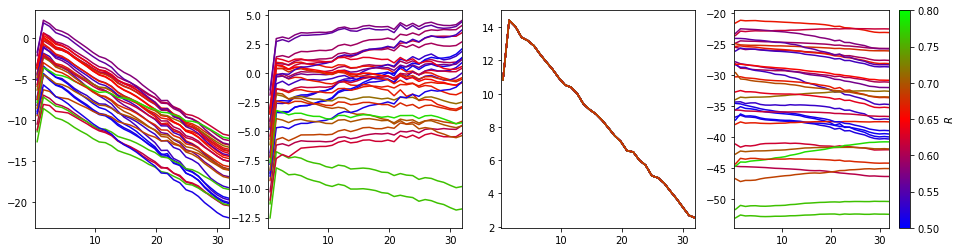

In [140]:
f, ax = pp.subplots(1,4,figsize=(16, 4))
N = 32
norm = colors.Normalize(0.5,0.8)
for j, y in enumerate([preds, np.float32(errs), Zs, fwd_probs]):
    pp.sca(ax[j])
    for i in range(N):
        pp.plot([temps[j * N + i] for j in range(N)],
                [y[j * N + i] for j in range(N)],
                c=cm.brg(norm(all_rewards[i])))
    pp.xlim(0.2,32)
pp.colorbar(cm.ScalarMappable(norm, cm.brg), label='$R$')

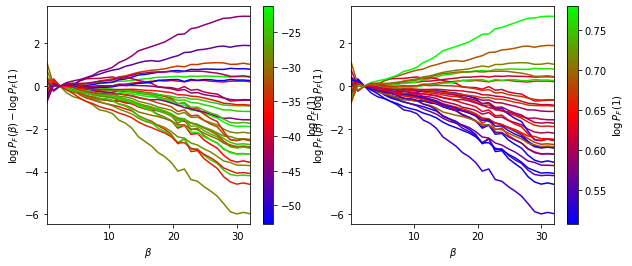

In [137]:
import matplotlib.cm as cm
from matplotlib import colors
f, ax = pp.subplots(1,2,figsize=(10,4))
ft = np.float32
_fwd_probs = ft(fwd_probs).reshape((32, 32))
rel_fwd_probs = (_fwd_probs - _fwd_probs[2][None, :])
for row, col in enumerate([_fwd_probs[2], ft(all_rewards[:32])]):
    pp.sca(ax[row])
    norm = colors.Normalize(vmin=col.min(), vmax=col.max())
    for i in range(32):
        pp.plot(np.linspace(0.2, 32, 32), rel_fwd_probs[:, i], c=cm.brg(norm(col[i])))
    pp.colorbar(cm.ScalarMappable(norm, cm.brg), label='$\\log P_F(1)$')
    pp.xlim(0.2, 32)
    pp.ylabel('$\\log P_F(\\beta) -\\log P_F(1)$')
    pp.xlabel('$\\beta$')

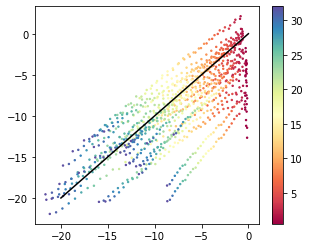

In [138]:
pp.figure(figsize=(5,4))
pp.scatter(targets, preds, s=2, c=ft(temps), cmap=cm.Spectral)
pp.plot([-20, 0], [-20, 0], color='black')
pp.colorbar()

In [123]:
np.mean((ft(errs) ** 2)  / ft(list(batch.traj_lens.cpu().numpy()) * 32))

12.736641

## Temperature trends for sampled trajs

In [21]:
from torch_scatter import scatter
sampler = qm9.TrajectoryBalance(env, ctx, np.random.default_rng(142857),
                                random_action_prob=0, max_nodes=9)
dev = model.device
inv_preds = []
preds = []
temps = []
Zs = []
fwd_probs = []
targets = []
errs = []

which_temp = 8

if 1:
    #graphs = [ctx.mol_to_graph(Chem.MolFromSmiles(smiles[0])) for _ in range(32)]
    #graphs = [i[0] for i in temp_res[4][:32]]
    #rewards = torch.tensor([rewards[0]] * 32)
    rewards = torch.tensor([i[1].exp() for i in temp_res[which_temp][:32]])
    trajs = [{'traj': i[3]} for i in temp_res[which_temp][:32]]#sampler.create_training_data_from_graphs(graphs)
    cond_info = torch.ones(len(graphs)).to(dev)[:, None]
    #rewards = torch.tensor(rewards).to(dev)
    batch = sampler.construct_batch(trajs, cond_info, rewards, model.action_type_order)
    batch.to(dev)
    batch_idx = torch.arange(batch.traj_lens.shape[0]).to(dev).repeat_interleave(batch.traj_lens)
    num_trajs = batch.traj_lens.shape[0]
    for temp in np.linspace(0.5, 32, 32):
        cat, r_pred = model(batch, cond_info[batch_idx] * temp)
        log_prob = cat.log_prob(batch.actions)
        traj_log_prob = scatter(log_prob, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')
        log_p_B = (1 / batch.num_backward).log()
        Rp = torch.maximum(batch.rewards.log() * temp, torch.tensor(-100.0, device=dev))
        P_B = scatter(log_p_B, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')
        Z = model.logZ(cond_info * temp)[:, 0]
        traj_mass = Z + traj_log_prob - P_B
        inv_preds += [i / temp for i in traj_log_prob.cpu().data.numpy()]
        preds += [i for i in traj_mass.cpu().data.numpy()]
        temps += list(cond_info.cpu().numpy() * temp)
        Zs += list(Z.data.cpu().numpy())
        fwd_probs += list(traj_log_prob.data.cpu().numpy())
        targets += list((batch.rewards ** temp).log().cpu().numpy())
        errs += list((Z + traj_log_prob - P_B - (batch.rewards ** temp).log()).data.cpu().numpy())
        

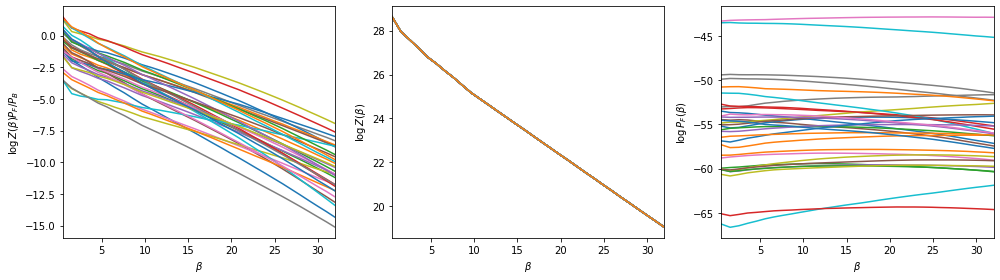

In [22]:
f, ax = pp.subplots(1,3,figsize=(14, 4))
N = 32
for j, y in enumerate([preds, Zs, fwd_probs]):
    pp.sca(ax[j])
    for i in range(N):
        pp.plot([temps[j * N + i] for j in range(N)],
                [y[j * N + i] for j in range(N)],
               )
    pp.xlabel('$\\beta$')
    pp.ylabel(['$\\log Z(\\beta) P_F / P_B$', '$\\log Z(\\beta)$', '$\\log P_F(\\beta)$'][j])
    pp.xlim(0.5,32)
pp.tight_layout()

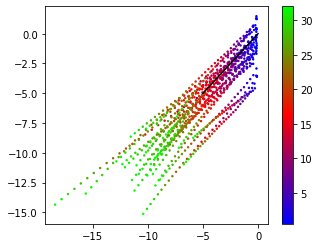

In [23]:
pp.figure(figsize=(5,4))
pp.scatter(targets, preds, s=2, c=ft(temps), cmap='brg')
pp.plot([-5, 0], [-5, 0], color='black')
pp.colorbar()

Text(0.5, 0, '$\\beta$')

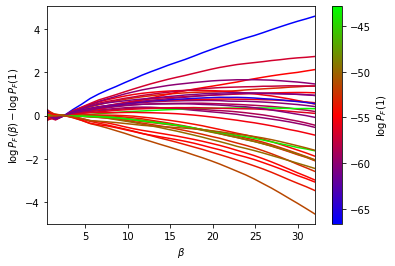

In [24]:
import matplotlib.cm as cm
from matplotlib import colors
ft = np.float32
_fwd_probs = ft(fwd_probs).reshape((32, 32))
rel_fwd_probs = (_fwd_probs - _fwd_probs[2][None, :])
norm = colors.Normalize(vmin=_fwd_probs.min(), vmax=_fwd_probs.max())
for i in range(32):
    pp.plot(np.linspace(0.5, 32, 32), rel_fwd_probs[:, i], c=cm.brg(norm(_fwd_probs[2, i])))
pp.colorbar(cm.ScalarMappable(norm, cm.brg), label='$\\log P_F(1)$')
pp.xlim(0.5, 32)
pp.ylabel('$\\log P_F(\\beta) -\\log P_F(1)$')
pp.xlabel('$\\beta$')

## How much variance is there between generated trajectories?

In [106]:
from torch_scatter import scatter
sampler = qm9.TrajectoryBalance(env, ctx, np.random.default_rng(142857),
                                random_action_prob=0, max_nodes=9)
dev = model.device
inv_preds = []
preds = []
temps = []
Zs = []
fwd_probs = []
targets = []
errs = []
for smiles, rewards in dl_test:
    graphs = [ctx.mol_to_graph(Chem.MolFromSmiles(smiles[0])) for _ in range(32)]
    rewards = torch.tensor([rewards[0]] * 32)
    trajs = sampler.create_training_data_from_graphs(graphs)
    cond_info = torch.ones(len(graphs)).to(dev)[:, None]
    #rewards = torch.tensor(rewards).to(dev)
    batch = sampler.construct_batch(trajs, cond_info, rewards, model.action_type_order)
    batch.to(dev)
    batch_idx = torch.arange(batch.traj_lens.shape[0]).to(dev).repeat_interleave(batch.traj_lens)
    num_trajs = batch.traj_lens.shape[0]
    for temp in np.linspace(0.5, 16, 32):
        cat, r_pred = model(batch, cond_info[batch_idx] * temp)
        log_prob = cat.log_prob(batch.actions)
        traj_log_prob = scatter(log_prob, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')
        log_p_B = (1 / batch.num_backward).log()
        Rp = torch.maximum(batch.rewards.log(), torch.tensor(-100.0, device=dev))
        P_B = scatter(log_p_B, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')
        Z = model.logZ(cond_info * temp)[:, 0]
        traj_mass = Z + traj_log_prob - P_B
        inv_preds += [i / temp for i in traj_log_prob.cpu().data.numpy()]
        preds += [i for i in traj_mass.cpu().data.numpy()]
        temps += list(cond_info.cpu().numpy() * temp)
        Zs += list(Z.data.cpu().numpy())
        fwd_probs += list(traj_log_prob.data.cpu().numpy())
        targets += list((batch.rewards ** temp).log().cpu().numpy())
        errs += list((Z + traj_log_prob - P_B - (batch.rewards ** temp).log()).data.cpu().numpy())
        
    break

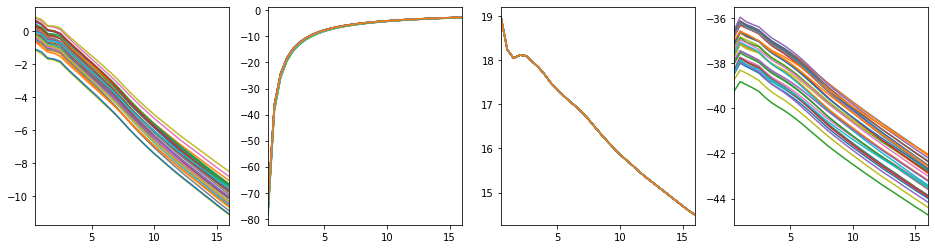

In [107]:
f, ax = pp.subplots(1,4,figsize=(16, 4))
N = 32
for j, y in enumerate([preds, inv_preds, Zs, fwd_probs]):
    pp.sca(ax[j])
    for i in range(N):
        pp.plot([temps[j * N + i] for j in range(N)],
                [y[j * N + i] for j in range(N)],
               )
    pp.xlim(0.5,16)

(array([18.,  7.,  4.,  0.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([1.2178112e-09, 1.0229609e-08, 1.9241407e-08, 2.8253206e-08,
        3.7265004e-08, 4.6276803e-08, 5.5288599e-08, 6.4300401e-08,
        7.3312194e-08, 8.2323993e-08, 9.1335792e-08], dtype=float32),
 <BarContainer object of 10 artists>)

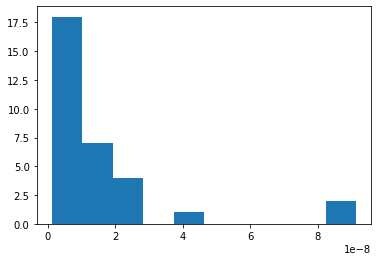

In [309]:
pp.hist(P_B.exp().cpu().numpy())

In [8]:
trainer = qm9.QM9SamplingIterator(data_train, model, 32 * 2, ctx, sampler, qm9.ConditionalTask('uniform', (0.5, 8)), 0.5, True)
trainer_loader = torch.utils.data.DataLoader(trainer, batch_size=None, num_workers=4, persistent_workers=True)

In [11]:
#key = "d5ada846-8f52-4f77-99d7-b1d37f82c320" # TBMSE
key = "2b8478b3-4e37-4368-88b6-1f802aac18ac" # TBMSE with too much Z lr decay
params = torch.load(f"/mnt/bh1/scratch/det_checkpoints/{key}/state_dict.pth")
model.load_state_dict(params['models_state_dict'][0])
model.cuda();

In [ ]:
Z_params = list(model.logZ.parameters())
non_Z_params = [i for i in model.parameters() if all(id(i) != id(j) for j in Z_params)]
opt = torch.optim.Adam(non_Z_params, 1e-4, (0.95, 0.999), 1e-8)
optZ = torch.optim.Adam(Z_params, 1e-4)
opt.load_state_dict(params['optimizers_state_dict'][0])
optZ.load_state_dict(params['optimizers_state_dict'][1])
sampler.tb_loss_is_mae = False
all_losses = []

In [33]:
qqqq = [model, opt, optZ, sampler]

In [32]:
batches = []
for t, batch in zip(range(100), trainer):
    batches.append(batch)
    batch.cuda()
    #losses, info = sampler.compute_batch_losses(model, batch, 32)
    
    num_trajs = batch.traj_lens.shape[0]
    rewards = batch.rewards
    cond_info = batch.cond_info

    # This index says which trajectory each graph belongs to, so
    # it will look like [0,0,0,0,1,1,1,2,...] if trajectory 0 is
    # of length 4, trajectory 1 of length 3, and so on.
    batch_idx = torch.arange(batch.traj_lens.shape[0], device=dev).repeat_interleave(batch.traj_lens)
    # The position of the last graph of each trajectory
    final_graph_idx = torch.cumsum(batch.traj_lens, 0) - 1

    # Forward pass of the model, returns a GraphActionCategorical and the optional bootstrap predictions
    fwd_cat, log_reward_preds = model(batch, cond_info[batch_idx])

    # Retreive the reward predictions for the full graphs,
    # i.e. the final graph of each trajectory
    log_reward_preds = log_reward_preds[final_graph_idx, 0]
    # Compute trajectory balance objective
    Z = model.logZ(cond_info)[:, 0]
    log_prob = fwd_cat.log_prob(batch.actions)
    log_p_B = (1 / batch.num_backward).log()
    Rp = torch.maximum(rewards.log(), torch.tensor(-100.0, device=dev))
    numerator = Z + scatter(log_prob, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')
    denominator = Rp + scatter(log_p_B, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')
    invalid_mask = (rewards < 1e-30).float()
    denominator = denominator * (1 - invalid_mask) + invalid_mask * (numerator.detach() - 10)
    
    traj_losses = (numerator - denominator).pow(2)
    losses = traj_losses / batch.traj_lens
    worst = losses.argmax()
    print(worst.item() < 32, losses.max().item(), invalid_mask.mean() * 2)
    print(log_prob[batch_idx == worst].data.cpu().numpy())
    print(Z[worst].item(), log_prob[batch_idx == worst].sum().item(), log_p_B[batch_idx == worst].sum().item(), Rp[worst].item())
    print(' '.join([f'{i.min():.3f}' for i in fwd_cat.logits]), '::',' '.join([f'{i.max():.3f}' for i in fwd_cat.logits]))
    all_losses.append(losses.data.cpu().numpy())
    loss = losses.mean()
    loss.backward()
    opt.step()
    opt.zero_grad()
    optZ.step()
    optZ.zero_grad()
    print(t, loss)
    print()

False 4.761904761904762 tensor(0.0625, device='cuda:0')
[-1.0650266 -0.56246   -1.2210262 -4.734989  -2.4693177 -4.380415
 -4.6521225 -4.372652  -2.9506946 -4.177942  -3.0230196 -3.1046152
 -3.6099794 -3.430355  -3.8695388 -3.4893918 -3.585692  -3.952664
 -3.6515121 -3.431913  -6.958851 ]
42.61565017700195 -72.69418334960938 -30.450088500976562 -99.98309303742752
-37.892 -114.564 -48.612 -45.819 -37.332 :: 6.506 11.689 5.073 3.568 4.486
0 tensor(0.1700, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

False 1.2640539900160495 tensor(0., device='cuda:0')
[ -0.5479658  -1.1398146  -1.2356052  -4.7111835  -4.354128   -2.6752253
  -4.5419374  -2.8722167  -3.550279   -2.6764762  -5.228039   -3.55238
  -3.6720753  -4.391161   -4.8329563  -3.1757154  -3.8191462 -10.203218
  -3.7636967  -2.9223616  -3.1011782  -3.5200315  -3.6957996  -2.447938
  -3.7589333  -3.3233037  -2.5994396]
41.732173919677734 -96.31220245361328 -46.84589767456055 -1.8921000466499793
-37.968 -115.441 -48.6

In [27]:
fwd_cat.logits[0].min()

tensor(-37.6987, device='cuda:0', grad_fn=<MinBackward1>)

In [394]:

num_trajs = batch.traj_lens.shape[0]
rewards = batch.rewards
cond_info = batch.cond_info

# This index says which trajectory each graph belongs to, so
# it will look like [0,0,0,0,1,1,1,2,...] if trajectory 0 is
# of length 4, trajectory 1 of length 3, and so on.
batch_idx = torch.arange(batch.traj_lens.shape[0], device=dev).repeat_interleave(batch.traj_lens)
# The position of the last graph of each trajectory
final_graph_idx = torch.cumsum(batch.traj_lens, 0) - 1

# Forward pass of the model, returns a GraphActionCategorical and the optional bootstrap predictions
fwd_cat, log_reward_preds = model(batch, cond_info[batch_idx])

# Retreive the reward predictions for the full graphs,
# i.e. the final graph of each trajectory
log_reward_preds = log_reward_preds[final_graph_idx, 0]
# Compute trajectory balance objective
Z = model.logZ(cond_info)[:, 0]
log_prob = fwd_cat.log_prob(batch.actions)
log_p_B = (1 / batch.num_backward).log()
Rp = torch.maximum(rewards.log(), torch.tensor(-100.0, device=dev))
numerator = Z + scatter(log_prob, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')
denominator = Rp + scatter(log_p_B, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')

In [399]:
Z[-2], scatter(log_prob, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')[-2], scatter(log_p_B, batch_idx, dim=0, dim_size=num_trajs, reduce='sum')[-2], Rp[-2]

(tensor(17.3923, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(-50.5322, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(-19.0038, device='cuda:0'),
 tensor(-1.1900, device='cuda:0', dtype=torch.float64))

In [407]:
log_prob[batch_idx == 62]

tensor([-0.1897, -2.1148, -0.8663, -2.8545, -1.3104, -1.5171, -3.3416, -4.7453,
        -2.1236, -4.9302, -4.5090, -4.1318, -3.7476, -3.5309, -5.4861, -3.5202,
        -1.6133], device='cuda:0', grad_fn=<IndexBackward>)

In [408]:
losses.argmax()

tensor(62, device='cuda:0')

In [402]:
(numerator[-2] - denominator[-2]).pow(2), info['unnorm_traj_losses'][-2]

(tensor(167.6027, device='cuda:0', dtype=torch.float64, grad_fn=<PowBackward0>),
 tensor(162.9320, device='cuda:0', dtype=torch.float64,
        grad_fn=<SelectBackward>))

8.42467e-09 26.919804


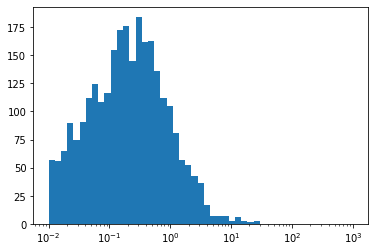

In [383]:
ls = np.float32(all_losses)[:, :32].reshape(-1)
print(ls.min(), ls.max())
pp.hist(ls, np.logspace(-2, 3))
pp.xscale('log')

In [381]:
np.float32(all_losses).shape

(100, 64)

In [349]:
g2 = np.concatenate([i['exp_avg_sq'].flatten().cpu().numpy() for k,i in params['optimizers_state_dict'][0]['state'].items()])

In [354]:
g = np.concatenate([i['exp_avg'].flatten().cpu().numpy() for k,i in params['optimizers_state_dict'][0]['state'].items()])

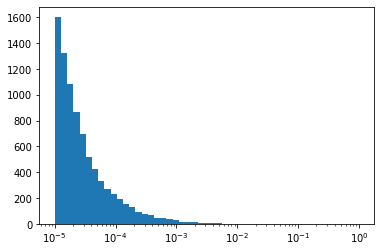

In [353]:
pp.hist(g2, np.logspace(-5, 0))
pp.xscale('log')

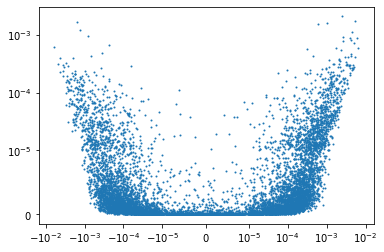

In [357]:
pp.scatter(g[:10000], g2[:10000], s=1)
pp.xscale('symlog', linthresh=1e-5)
pp.yscale('symlog', linthresh=1e-5)

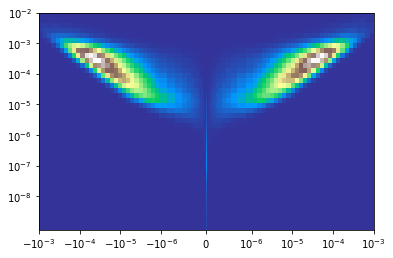

In [373]:
sy = np.logspace(-10, -2)
sx = np.logspace(-8, -3)
pp.hist2d(g, np.sqrt(g2), [np.concatenate([-sx[::-1], sx]), sy], cmap='terrain')
pp.xscale('symlog', linthresh=1e-6)
pp.yscale('symlog', linthresh=1e-8)

In [200]:
import torch.nn as nn

In [202]:
l = torch.tensor([0.1, 1, 0.1, 0.1], requires_grad=True)
x = nn.Softmax(0)(l)
torch.autograd.grad(x[0], l)

(tensor([ 0.1496, -0.0825, -0.0335, -0.0335]),)

In [14]:
data_train.df[data_train.df['gap'] > 0.4]

,SMILES,rA,rB,rC,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
0,C,157.71180,157.70997,157.70699,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469
6,CC,80.46225,19.90649,19.90633,0.0000,23.95,-0.3385,0.1041,0.4426,109.5031,0.074542,-79.764152,-79.760666,-79.759722,-79.787269,10.098
12,CCC,29.45018,8.37701,7.42076,0.0597,34.75,-0.3230,0.0949,0.4179,227.1361,0.103182,-119.052475,-119.047927,-119.046983,-119.078157,14.840
20,CC(C)C,7.75166,7.74847,4.48668,0.0897,45.46,-0.3167,0.0843,0.4010,355.0621,0.131146,-158.342346,-158.336603,-158.335658,-158.370016,20.273
38,CCCC,23.44662,3.60588,3.38683,0.0000,45.71,-0.3170,0.0937,0.4107,426.2996,0.131708,-158.340943,-158.335170,-158.334226,-158.368940,19.668
104,C1C2CC1C2,7.20812,7.20681,6.22176,0.0002,49.82,-0.2974,0.1082,0.4056,328.2069,0.116844,-195.158734,-195.154774,-195.153830,-195.185188,15.584
132,CCCCC,17.04187,1.92713,1.82903,0.0603,56.80,-0.3105,0.0925,0.4030,721.0614,0.160138,-197.629416,-197.622321,-197.621376,-197.659721,24.552
183,FC(F)(F)F,5.71326,5.71279,5.71267,0.0003,15.93,-0.4286,0.1935,0.6221,279.3208,0.017147,-437.484875,-437.480956,-437.480011,-437.512059,12.639
830,CCC(F)(F)F,5.21686,2.75151,2.72562,2.0586,35.84,-0.3543,0.0922,0.4465,529.7582,0.080927,-416.814878,-416.808720,-416.807775,-416.844830,21.285
4227,CCCC(F)(F)F,4.90629,1.44595,1.42647,2.1377,46.73,-0.3446,0.0860,0.4306,885.3722,0.109275,-456.103432,-456.095918,-456.094973,-456.135756,26.166


Text(0, 0.5, 'p(R)')

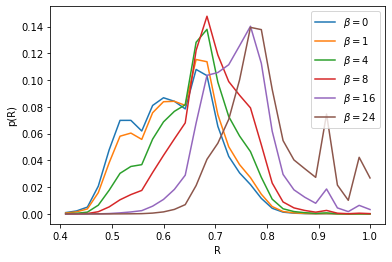

In [60]:
r0 = data_train.reward_transform(data_train.df['gap'])
xr = np.linspace(0.4,1.01,30)
b0 = np.digitize(r0, xr)
for t in [0,1,4,8,16,24]:
    px = r0 ** t / (r0 ** t).sum()
    pp.plot(xr[1:] - (xr[1]-xr[0])/2, np.bincount(b0, px)[1:], label=f'$\\beta={t}$')
pp.legend()
pp.xlabel('R')
pp.ylabel('p(R)')

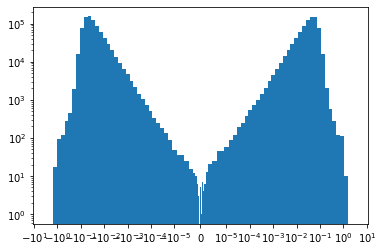

In [117]:
g = np.concatenate([i.data.flatten().cpu().numpy() for i in model.parameters()])
pp.hist(g, np.concatenate([-np.logspace(-7,1)[::-1], np.logspace(-7,1)]))
pp.yscale('log')
pp.xscale('symlog', linthresh=1e-5)

In [118]:
g.min(), g.max()

(-1.1593559, 1.1258054)

In [19]:
!pip install psi4

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement psi4 (from versions: none)
ERROR: No matching distribution found for psi4


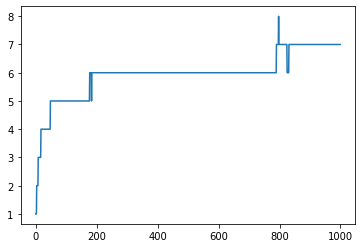

In [30]:
pp.plot([Chem.MolFromSmiles(i).GetNumAtoms() for i in data_train.df.SMILES[:1000]])

0.04997572543600851


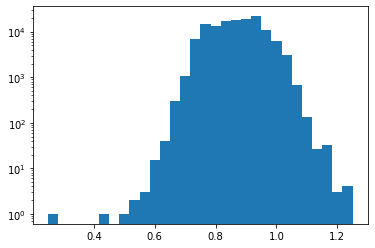

In [8]:
g = data_train.df['gap']
r = 1 - (g - data_train._min) / (data_train._gap + 1e-4)
r_95p = np.sort(r)[int(r.shape[0] * 0.95)]
r = r + (1 - r_95p)
print(np.mean(r > 1))
pp.hist(r, 30);
pp.yscale('log')

0.04997572543600851 0.1741 0.7497907949790795


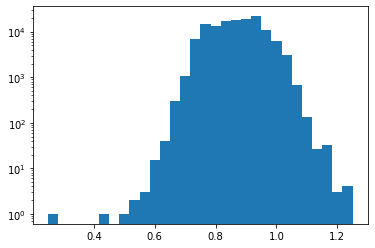

In [29]:
g = data_train.df['gap']
r_95p = np.sort(g)[int(g.shape[0] * 0.05)]
r = 1 - (g - r_95p) / (data_train._gap)
#r = r + 1 - (r_95p - data_train._min) / (data_train._gap)
print(np.mean(r > 1), r_95p, 1 - (r_95p - data_train._min) / (data_train._gap))
pp.hist(r, 30);
pp.yscale('log')

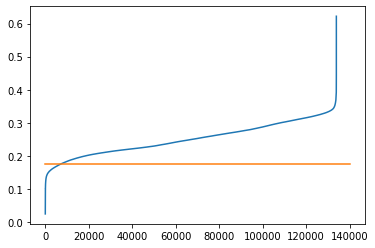

In [23]:
pp.plot(np.sort(g))
pp.plot([0,140000],[r_95p, r_95p])

In [30]:
import scipy.stats

In [46]:
scipy.stats.gamma.cdf(1, 2, scale=2)

0.09020401043104986

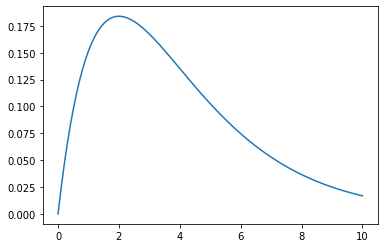

In [40]:
x = np.linspace(0,10,100)
pp.plot(x, scipy.stats.gamma.pdf(x, 2, scale=2))

In [41]:
asd = np.random.default_rng().gamma(2,2, 10000)

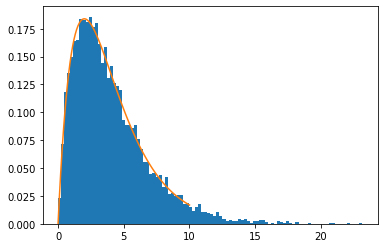

In [45]:
pp.hist(asd, 100, density=True);
x = np.linspace(0,10,100)
pp.plot(x, scipy.stats.gamma.pdf(x, 2, scale=2))

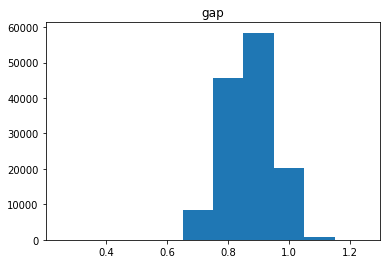

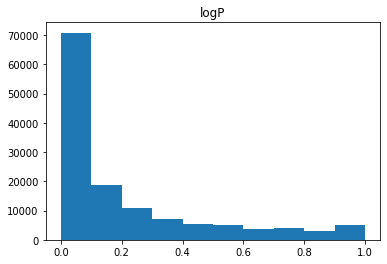

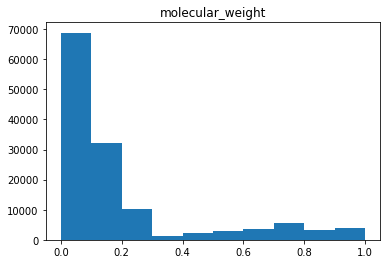

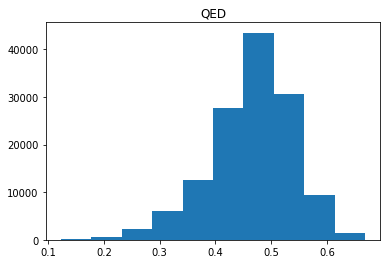

<Figure size 432x288 with 0 Axes>

In [92]:
import matplotlib.pyplot as plt 
targets = ["gap", "logP", "molecular_weight", "QED"]
number_of_objectives=4
reward_stat_info = []
def logP_reward_new(_input, _info):
    return np.exp(-(_input - 2.5) ** 2 / (2 *_info._std))


def qed_reward_new(_input, _info):
    return _input
    # return np.exp(-(_input - 0.7) ** 2 / (1*_info._width))

def molecular_weight_reward_new(_input, _info):
    return np.exp(-(_input - 105) ** 2 / (1.2* _info._width))
for i in range(number_of_objectives):
    _min, _max, _median,  _percentile_95, _std = data_train.get_stats(percentile=0.05, target=targets[i])
    reward_stat_info = RewardInfo(_min=_min, _max=_max, _median=_median, _percentile_95=_percentile_95, _std=_std)
    if targets[i] == 'gap':
        rew = gap_reward(data_train.df[targets[i]], reward_stat_info)
    elif targets[i] == 'logP':
        rew = logP_reward_new(data_train.df[targets[i]], reward_stat_info)
    elif targets[i] == 'molecular_weight':
        rew = molecular_weight_reward_new(data_train.df[targets[i]], reward_stat_info)
    else:
        rew = qed_reward_new(data_train.df[targets[i]], reward_stat_info)
    plt.hist(rew)
    plt.title(targets[i])
    plt.show()
    plt.clf()

In [21]:
import numpy as np
a = np.asarray([[0.520, 0.0], [0, 1.4796]]).clip(1e-4, 2)
print(a)


[[5.2000e-01 1.0000e-04]
 [1.0000e-04 1.4796e+00]]


In [25]:
import torch
from itertools import product

In [34]:
spaces = [np.linspace(0.0, 1.0, 120) for _ in range(2)]
test_preferences = torch.tensor([comb for comb in product(*spaces)
                 if np.allclose(sum(comb), 1.0)]).float()
test_preferences = torch.repeat_interleave(test_preferences, 50, dim=0)

In [35]:
beta = np.ones(120).astype(np.float32)
beta = beta * 32

In [36]:
beta = np.repeat(beta, 50, -1)
print(beta.shape)
def thermometer(v, n_bins=50, vmin=0, vmax=1):
    bins = torch.linspace(vmin, vmax, n_bins)
    gap = bins[1] - bins[0]
    return (v[..., None] - bins.reshape((1,) * v.ndim + (-1,))).clamp(0, gap.item()) / gap


(6000,)


In [37]:
beta_enc = thermometer(torch.tensor(beta), 32, 0, 32)

In [39]:
encoding = torch.cat([test_preferences, beta_enc], dim=-1)

In [38]:
print(test_preferences.shape, beta_enc.shape)

torch.Size([6000, 2]) torch.Size([6000, 32])


In [40]:
print(encoding.shape)

torch.Size([6000, 34])
